In [1]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import \
    get_base_prior_parameters, get_base_sufficient_parameters, get_base_moment_parameters, \
    set_moments, get_e_log_prior, e_data_log_lik, get_e_random_effect_log_lik, \
    get_entropy, get_elbo_model_term, get_elbo, \
    LMMDataCache, CoordinateAscentUpdater, KLWrapper, MomentWrapper

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

import time

In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

# Simulate data
N = 10     # observations per group
K = 10      # dimension of regressors
NG = 3000      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(K))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 0.0
true_mu_info = 40.0
true_u = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u[y_g_vec]
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

prior_par = get_base_prior_parameters(K)

print N * NG

30000


In [3]:
lmm_par = get_base_sufficient_parameters(K, NG)
free_par_vec = lmm_par.get_free()

In [4]:
# Define moment parameters
moment_par = get_base_moment_parameters(K, NG)
set_moments(lmm_par, moment_par)
init_moment_par = copy.deepcopy(moment_par)
init_par_vec = lmm_par.get_free()

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [5]:
get_e_log_prior(moment_par, prior_par)
get_e_random_effect_log_lik(moment_par)
data_cache = LMMDataCache(x_mat, y_vec, y_g_vec)
e_data_log_lik(data_cache, moment_par)
get_elbo_model_term(data_cache, moment_par, prior_par)

-157756.56836807134

In [6]:
# Perform coordinate ascent.

ca_updater = CoordinateAscentUpdater(init_moment_par, data_cache, prior_par)

ca_time = time.time()
tol = 1e-9
delta = float('inf')
while delta > tol:
    delta = ca_updater.update()
    print delta
ca_time = time.time() - ca_time

ca_moment_par_opt = copy.deepcopy(ca_updater.moment_par)

print 'Coordinate ascent time (in minutes):'
print ca_time / 60.

3322.04156748
466.817237923
220.413838515
124.160944026
79.1818426716
55.2623887668
41.0167698828
31.7885321383
25.430387871
20.8412090855
17.4067784205
14.7611297859
12.6744224662
10.9959740464
9.62340808999
8.4850392372
7.52936015414
6.71852571875
6.02418063332
5.42471062566
4.90338568253
4.44707773012
4.04535734242
3.68984603388
3.37374430178
3.09148268055
2.83846029292
2.61084655903
2.40542911371
2.21949595374
2.05074323387
1.89720248726
1.75718270209
1.62922386536
1.51205943451
1.40458581554
1.3058373816
1.21496590371
1.13122351878
1.05394855114
0.982553649951
0.916515816579
0.855367982686
0.79869186706
0.746111892036
0.697289981928
0.651921098841
0.609729397566
0.570464902239
0.533900624506
0.499830056561
0.468064983663
0.438433569787
0.410778677582
0.384956389929
0.360834705483
0.338292384809
0.31721792722
0.297508661361
0.279069935046
0.261814391924
0.24566132427
0.230536092706
0.216369604881
0.20309784622
0.190661456738
0.179005348719
0.168078360705
0.157832943813
0.1482248769

In [7]:
print get_elbo_model_term(data_cache, moment_par, prior_par)
print get_entropy(lmm_par)
print get_elbo(data_cache, lmm_par, moment_par, prior_par)

-157756.568368
4274.42392348
-153482.144445


In [8]:
kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, 20)
print kl_wrapper.kl(free_par_vec)

import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.kl(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: kl_wrapper.kl_grad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: kl_wrapper.kl_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num

153482.144445
Function time:
0.00117790699005
Grad time:
0.00852539539337
Hessian vector product time:
0.0170342206955


In [10]:
# Optimize.
vb_time = time.time()

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.kl(par, verbose=True),
    trust_init, method='trust-ncg', jac=kl_wrapper.kl_grad, hessp=kl_wrapper.kl_hvp,
    tol=1e-6, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
153482.144445
87767.8705946
72445.8770081
60409.4540189
49893.5095048
42552.5985253
32256.3180879
30615.4430714
58913.8272956
26247.2421059
24935.8281415
24549.9984802
23800.542899
22827.6325799
22822.4698116
22234.4058483
22125.4087492
21168.0856763
20905.6695374
20902.2778159
19521.8194541
18934.6816519
18921.8068124
16657.0781509
16207.8199929
16110.9478827
16107.0626922
13454.7442275
13315.7579625
13310.3263353
12803.5023345
12799.5298377
12799.3022509
12721.1476369
12720.7092279
12720.2340991
12722.7831817
12722.7831817
12722.7831817
12717.5197954
12717.2909469
12717.0208665
12717.0182547
12715.9514635
12711.9546694
12711.9224954
12711.8326821
12710.648088
12705.4408112
12704.8496697
12704.5433855
12702.9958849
12702.9924465
12702.9887945
12702.9476239
12702.9476197
12702.947565
12702.9469633
12702.9469631
12702.946963
Optimization terminated successfully.
         Current function value: 12702.946963
         Iterations: 59
         Function evaluation

In [11]:
moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

# Make sure the coordinate ascent and trust region are close
moment_diff = np.sum(np.abs(ca_moment_par_opt.get_vector() - moment_par_opt.get_vector()))

print 'total moment difference: %f' % moment_diff
print 'trust region seconds: %f' % vb_time
print 'coordinate ascent seconds: %f' % ca_time

total moment difference: 0.000000
trust region seconds: 9.790628
coordinate ascent seconds: 2.628577


--------------- beta:

[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
[-4.56412316 -3.51490132 -2.51610525 -1.53470924 -0.48354587  0.50480677
  1.5121393   2.52295772  3.51376302  4.47081184]
--------------- mu:

0.00537266424892
0.0
--------------- mu info:

32.0692220689
40.0
--------------- y info:

0.998601584489
1.0


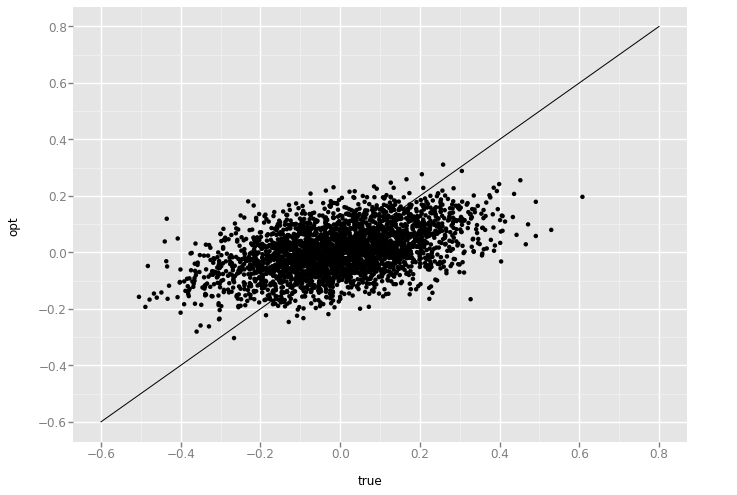

<ggplot: (8748781864665)>


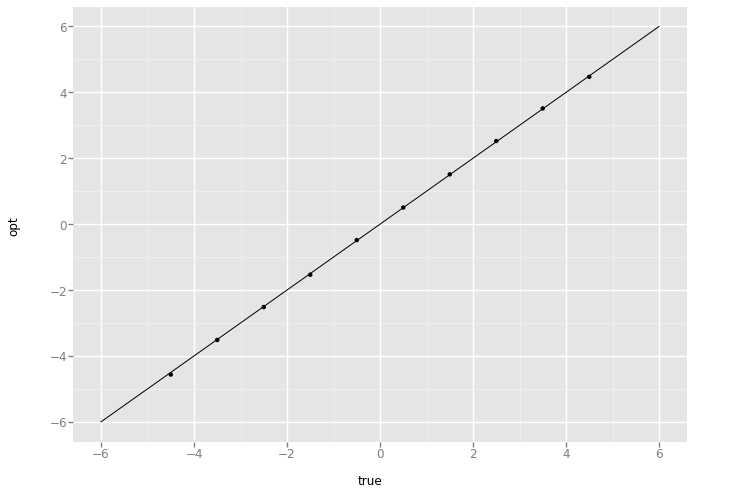

<ggplot: (8748781864649)>


In [12]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

e_u = lmm_par_opt['u'].e()

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [ ]:
# Slow, but probably faster than using CG if you want the covariance of many parameters.
hess_time = time.time()
print 'Calculating KL Hessian...'
kl_hess = kl_wrapper.kl_hess(vb_opt.x)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess
print 'Done.'

print 'Hessian time (seconds): %f' % hess_time

In [ ]:
hess_norm = np.sqrt(np.sum(kl_hess**2))
diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# How diagonal is the Hessian?
print 'Proportion of the frobenius norm off the diagonal:'
print (hess_norm - diag_norm) / hess_norm

In [ ]:
# moment_wrapper = MomentWrapper(lmm_par, moment_par)
#
# jac_time = time.time()
# print 'Calculating the moment Jacobian...'
# moment_jac = MomentJacobian(vb_opt.x)
# jac_time =  time.time() - hess_time
# print 'Done.'

# print 'Jacobian time (seconds): %f' % jac_time

In [ ]:
# lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

# prior_indices = copy.deepcopy(prior_par)
# prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

# vp_indices = copy.deepcopy(lmm_par_opt)
# vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))